<a href="https://colab.research.google.com/github/diveu/some_notebooks/blob/main/DLS_%5Bhw%5Dgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
!gdown -q --fuzzy https://drive.google.com/file/d/1zKi778-8cOI589T0J5DaXJBvSf1_C_f0/view?usp=drive_link

In [3]:
! unzip -q -o archive.zip

In [4]:
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [5]:
from os import listdir
from os.path import isfile, join
import os
from pathlib import Path

In [6]:
RESCALE_SIZE = 128

BATCH_SIZE = 64

DEVICE = torch.device('cuda') if  torch.cuda.is_available() else torch.device('cpu')
print(f'Current device: {DEVICE}')

# Директория с изображениями
DATA_DIR = Path('faces_dataset_small')

Current device: cuda


In [7]:
import torchvision.transforms as tfs

In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset

class FacesDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Open the image
        if self.transform:
            image = self.transform(image)  # Apply transformations if any
        return image  # Return the image and optionally the file path


In [9]:
def get_dataloader(data_dir, batch_size, image_size):
    """
    Создает DataLoader для изображений.

    Args:
        data_dir: Путь к директории с изображениями.
        batch_size: Размер батча.
        image_size: Размер изображения.

    Returns:
        DataLoader: DataLoader для изображений.
    """
    transform = tt.Compose([
        tt.Resize((image_size, image_size), interpolation=tfs.InterpolationMode.BICUBIC),
        tt.RandomHorizontalFlip(p=0.5),
        tt.ToTensor(),
        tt.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    dataset = FacesDataset(data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    return dataloader


In [10]:
def denorm(image):
    return image*0.5+0.5

In [11]:
image_size = 128

#TODO: build dataloader and transfer it to device

In [12]:
dataloader = get_dataloader(DATA_DIR, BATCH_SIZE, image_size)

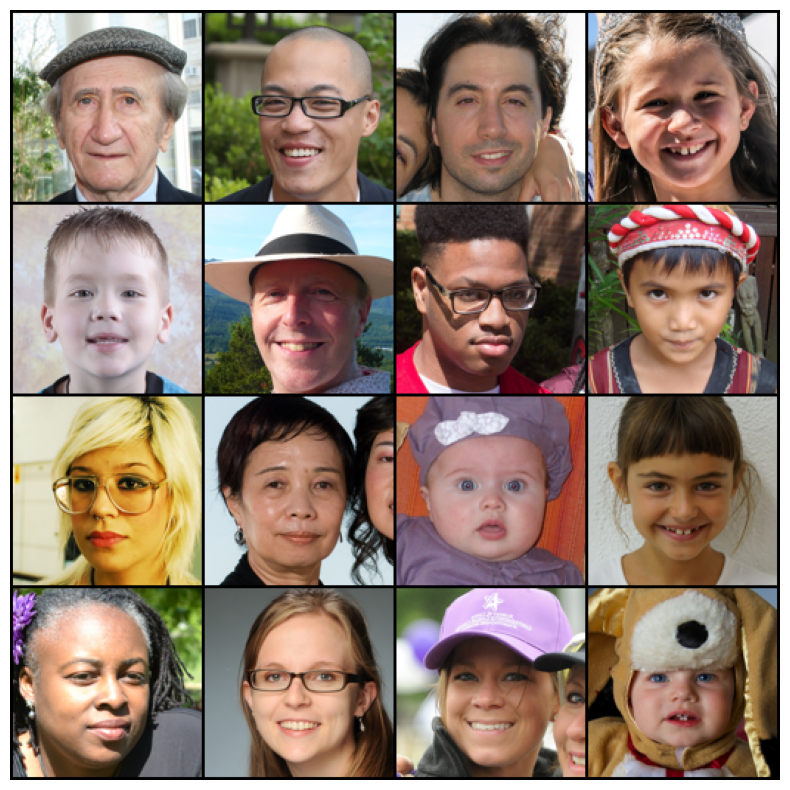

In [13]:
# Get a batch of images from the dataloader
dataiter = iter(dataloader)
images = next(dataiter)

# Create a grid of images
img_grid = make_grid(denorm(images[:16]), nrow=4)

# Plot the images
plt.figure(figsize=(10, 10))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()


In [14]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
dataloader = get_dataloader(DATA_DIR, BATCH_SIZE, image_size)

In [16]:
faces_dataloader = DeviceDataLoader(dataloader, DEVICE)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [17]:
class GaussianNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

class Discriminator(nn.Module):
    def __init__(self, image_size, fl_channels):
        super().__init__()
        num_iters = int(np.log2(image_size)-3) # number of iterations needed to go down to 1
        self.layers = nn.Sequential(
            GaussianNoise(),
            nn.Conv2d(3, fl_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        for i in range(num_iters):
            self.layers.append(GaussianNoise())
            self.layers.append(nn.Conv2d(fl_channels*2**i, fl_channels*2**(i+1), kernel_size=4, stride=2, padding=1, bias=False))
            self.layers.append(nn.BatchNorm2d(fl_channels*2**(i+1)))
            self.layers.append(nn.LeakyReLU(0.2, inplace=True))

        self.layers.append(GaussianNoise())
        self.layers.append(nn.Conv2d(fl_channels*2**num_iters, 1, kernel_size=4, stride=1, padding=0, bias=False))
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Sigmoid())

    def forward(self, x):
        return self.layers(x)

In [18]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, fl_channels):
        super().__init__()
        num_iters = int(np.log2(image_size)-3) # the number of iterations needed to upsample to the initial size
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(latent_size, fl_channels*2**num_iters, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(fl_channels*2**num_iters),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2)
        )
        for i in range(num_iters, 0, -1):
            self.layers.append(nn.ConvTranspose2d(fl_channels*2**i, fl_channels*2**(i-1), kernel_size=4, stride=2, padding=1, bias=False))
            self.layers.append(nn.BatchNorm2d(fl_channels*2**(i-1)))
            self.layers.append(nn.LeakyReLU(0.2, inplace=True))
            self.layers.append(nn.Dropout2d(0.2))

        self.layers.append(nn.ConvTranspose2d(fl_channels, 3, kernel_size=4, stride=2, padding=1, bias=False))
        self.layers.append(nn.Tanh())

    def forward(self, x):
        return self.layers(x)

In [19]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [20]:
@torch.no_grad()
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    # print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [21]:
discriminator =  Discriminator(image_size, 64).to(DEVICE)
latent_size = 128
generator = Generator(latent_size, image_size, 64).to(DEVICE)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [22]:
lr = 0.0002

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [23]:
def fit(model, criterion, epochs, lr, fixed_latent, start_idx=1):
    # setting both models to train and initializing it with 0 and empty arrays
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    sched_d = torch.optim.lr_scheduler.MultiStepLR(optimizer['discriminator'], milestones=[75,150,225,300], gamma=0.9)
    sched_g = torch.optim.lr_scheduler.MultiStepLR(optimizer['generator'], milestones=[150,225,300], gamma=0.9)
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(faces_dataloader):
            # images are already on device)
            optimizer["discriminator"].zero_grad()
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=DEVICE) #setting labels to 1 for real imgs
            loss_real = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            # Generate fake images
            latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=DEVICE) # labels 0 for fake
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = loss_real + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            # Train generator

            #clearing gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)
            # Try to fool the discriminator

            preds = model["discriminator"](fake_images)
            targets = torch.ones(BATCH_SIZE, 1, device=DEVICE)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        print(f"Epoch {epoch+1}/{epochs} loss_g: {losses_g[-1]} loss_d: {losses_d[-1]} real_score: {real_scores[-1]} fake_score: {fake_scores[-1]}")
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
        sched_d.step()
        sched_g.step()
    return losses_g, losses_d, real_scores, fake_scores

In [24]:
epochs = 40

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [25]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=DEVICE)
fake_images = model["generator"](fixed_latent)

In [ ]:
history = fit(model, criterion, epochs, lr, fixed_latent=fixed_latent)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/40 loss_g: 9.073489575386047 loss_d: 0.9520297399163247 real_score: 0.8022662103176117 fake_score: 0.19686525114651887


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/40 loss_g: 4.32129221200943 loss_d: 0.8374037992954254 real_score: 0.74147376537323 fake_score: 0.24218652724288403


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/40 loss_g: 3.224192826747894 loss_d: 0.8342728984355926 real_score: 0.7424731740355491 fake_score: 0.26875122118741274


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/40 loss_g: 3.259523572921753 loss_d: 0.8652441781759262 real_score: 0.7399016770720482 fake_score: 0.2698175963945687


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/40 loss_g: 3.7527830851078035 loss_d: 0.7011561518907548 real_score: 0.7896781265735626 fake_score: 0.23566001657396554


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/40 loss_g: 3.3687000964581966 loss_d: 1.0069990056753158 real_score: 0.7134489418566227 fake_score: 0.2678410677239299


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/40 loss_g: 3.309512332677841 loss_d: 0.9517973726987838 real_score: 0.721534980237484 fake_score: 0.28109229361638427


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/40 loss_g: 3.1939648675918577 loss_d: 0.8664235270023346 real_score: 0.7227183786034584 fake_score: 0.2856591396778822


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/40 loss_g: 3.0859664088487624 loss_d: 0.8871816694736481 real_score: 0.7279733178019524 fake_score: 0.2644462209194899


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/40 loss_g: 3.1133007431030273 loss_d: 0.8580982753634453 real_score: 0.7209931677579879 fake_score: 0.28163178753107787


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/40 loss_g: 3.0823013150691985 loss_d: 0.9002509522438049 real_score: 0.7255197580903768 fake_score: 0.26109625965822486


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/40 loss_g: 2.7452136784791947 loss_d: 0.9469489145278931 real_score: 0.7244075707346201 fake_score: 0.2921625137515366


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/40 loss_g: 3.1940134418010713 loss_d: 0.9433731931447983 real_score: 0.7042483574151993 fake_score: 0.28717741776257755


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/40 loss_g: 3.1721528804302217 loss_d: 0.909419122338295 real_score: 0.7378944409638644 fake_score: 0.2704027014272288


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/40 loss_g: 3.0535777708888054 loss_d: 0.7560480487346649 real_score: 0.7449341911077499 fake_score: 0.25769030511379243


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/40 loss_g: 3.267584745287895 loss_d: 0.7202332526445389 real_score: 0.7636640861630439 fake_score: 0.23554179588332771


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/40 loss_g: 2.8926094394922255 loss_d: 0.9106274032592774 real_score: 0.7012509202957153 fake_score: 0.30239111244678496


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/40 loss_g: 3.2622412240505216 loss_d: 0.9736675107479096 real_score: 0.7043279013037682 fake_score: 0.29743895899504424


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/40 loss_g: 3.396522126197815 loss_d: 0.8583094716072083 real_score: 0.723160143494606 fake_score: 0.2758753678575158


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/40 loss_g: 3.1437622785568236 loss_d: 0.8742732262611389 real_score: 0.7086492669582367 fake_score: 0.27956145741045474


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/40 loss_g: 3.441985046863556 loss_d: 0.8072016334533691 real_score: 0.7489327293634415 fake_score: 0.25119509633630516


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/40 loss_g: 3.2080827808380126 loss_d: 0.9115194129943848 real_score: 0.7197205944359303 fake_score: 0.28890550147742033


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/40 loss_g: 3.344558653831482 loss_d: 0.7849957054853439 real_score: 0.7403590553998947 fake_score: 0.25351788237690925


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/40 loss_g: 3.17527987241745 loss_d: 0.8046889674663543 real_score: 0.7302533727884293 fake_score: 0.25541715390980246


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/40 loss_g: 3.304891309738159 loss_d: 0.7960504925251007 real_score: 0.7453508561849594 fake_score: 0.24741032179445027


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/40 loss_g: 3.4271768379211425 loss_d: 0.8636163085699081 real_score: 0.7380235616490245 fake_score: 0.26156536931172014


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/40 loss_g: 3.444140784740448 loss_d: 0.7941059482097625 real_score: 0.7502017253637314 fake_score: 0.2594864789955318


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/40 loss_g: 3.4300916635990144 loss_d: 0.8071910399198532 real_score: 0.7433300703763962 fake_score: 0.25193116733804344


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/40 loss_g: 3.554466006755829 loss_d: 0.5890110981464386 real_score: 0.7912641540169716 fake_score: 0.2091324548376724


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/40 loss_g: 3.247182483077049 loss_d: 0.836435597538948 real_score: 0.720416109263897 fake_score: 0.25993718072772026


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/40 loss_g: 3.6652787375450133 loss_d: 0.7848852038383484 real_score: 0.7666476112604141 fake_score: 0.250707874558866


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32/40 loss_g: 3.6571969532966615 loss_d: 0.7912351822853089 real_score: 0.7467790588736534 fake_score: 0.23403280609287322


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33/40 loss_g: 3.3237278413772584 loss_d: 0.883876513838768 real_score: 0.7297563167661428 fake_score: 0.27111014153808355


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34/40 loss_g: 3.4482732152938844 loss_d: 0.7420580160617828 real_score: 0.7601673063635827 fake_score: 0.24459919644519687


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35/40 loss_g: 3.5568879425525664 loss_d: 0.7468337401747703 real_score: 0.7646007311344146 fake_score: 0.2239992053154856


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/40 loss_g: 3.582806556224823 loss_d: 0.6666079831123352 real_score: 0.7880180501192808 fake_score: 0.21827187203336507


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37/40 loss_g: 3.8019696855545044 loss_d: 0.6372414690256119 real_score: 0.787734661102295 fake_score: 0.2111287466576323


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38/40 loss_g: 3.7862462496757505 loss_d: 0.6865508925914764 real_score: 0.7785204261541366 fake_score: 0.22302079152315854


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39/40 loss_g: 3.63382942199707 loss_d: 0.6201249685883522 real_score: 0.7863349339365959 fake_score: 0.202478068433702


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40/40 loss_g: 3.8499822247028352 loss_d: 0.6356737846136093 real_score: 0.7965212976932525 fake_score: 0.20782062070444227


In [ ]:
#torch.save(model["generator"].state_dict(), 'generator.pth')
#torch.save(model["discriminator"].state_dict(), 'discriminator.pth')


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Они довольно статичны до 30й эпохи и там уже начинается какое-то движение. Стоит добавить ещё эпох, чтобы лучше усвоились распределения!

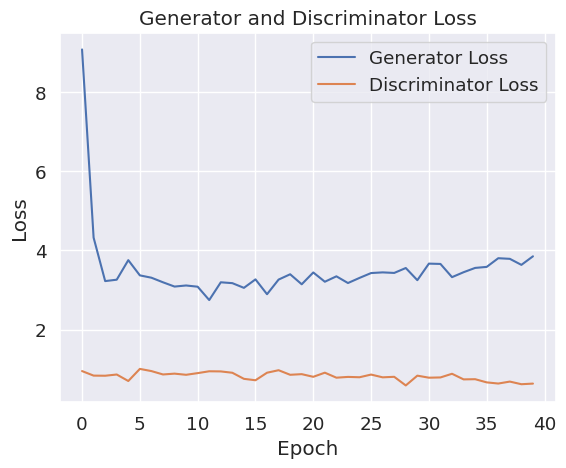

In [ ]:

plt.plot(losses_g, label='Generator Loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss')
plt.legend()
plt.show()


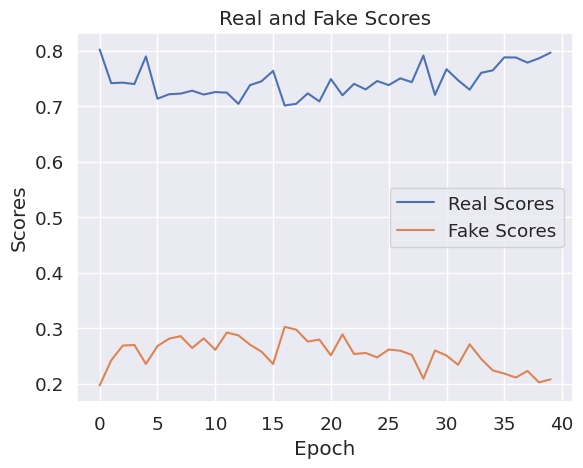

In [ ]:

plt.plot(real_scores, label='Real Scores')
plt.plot(fake_scores, label='Fake Scores')
plt.xlabel('Epoch')
plt.ylabel('Scores')
plt.title('Real and Fake Scores')
plt.legend()
plt.show()


In [27]:
model['generator'].load_state_dict(torch.load('generator.pth'))
model['discriminator'].load_state_dict(torch.load('discriminator.pth'))

<ipython-input-27-cd4e3386822f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model['generator'].load_state_dict(torch.load('generator.pth'))
<ipython-input-27-cd4e338682

<All keys matched successfully>

In [28]:
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=DEVICE)
fake_images = model["generator"](fixed_latent)

In [29]:
def show_images(generated, scale):
  with torch.no_grad():
    size = int(np.sqrt(len(generated)))
    fig, ax = plt.subplots(figsize=(size*scale, size*scale))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(generated).cpu().detach(), nrow=size).permute(1, 2, 0))

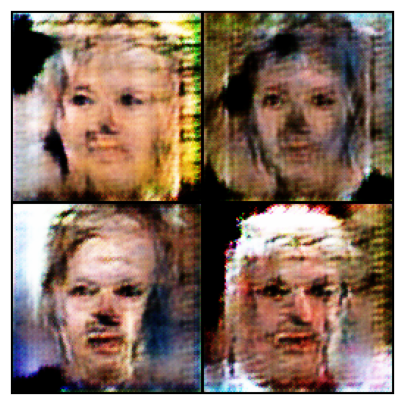

In [30]:
show_images(fake_images, 2.5)

Как вам качество получившихся изображений?

**ОЧЕНЬ ОЧЕНЬ ПЛОХО**

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import pandas as pd

In [ ]:
#dataloader.dataset.__len__()

3143

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

2652

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import numpy as np

# Generate fake images
num_real_images = len(dataloader.dataset)
fake_images_list = []
with torch.no_grad():
  for _ in tqdm(range(num_real_images // BATCH_SIZE + 1)):
    latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=DEVICE)
    fake_images = model["generator"](latent).cpu().detach().numpy()
    fake_images_list.extend(fake_images)
fake_images_np = np.array(fake_images_list[:num_real_images])

# Prepare real images
real_images_np = []
for i in tqdm(range(num_real_images)):
  real_images_np.append(dataloader.dataset[i].cpu().detach().numpy())
real_images_np = np.array(real_images_np)

# Flatten images for 1NN classifier
X = np.concatenate([fake_images_np.reshape(num_real_images, -1), real_images_np.reshape(num_real_images, -1)])
y = np.concatenate([np.zeros(num_real_images), np.ones(num_real_images)])

# Perform leave-one-out cross-validation
loo = LeaveOneOut()
y_pred = []
y_true = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    y_pred.append(knn.predict(X_test)[0])
    y_true.append(y_test[0])

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Leave-one-out accuracy:", accuracy)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/3143 [00:00<?, ?it/s]

Leave-one-out accuracy: 0.9430480432707604


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Как и ожидалось: картинки генерятся не очень, и поэтому accuracy вышел высоким. Очевидно, что лица всё же не очень похожи на живых людей, а скорее на кошмарную версию :)

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [32]:
import numpy as np
# Generate fake images
num_real_images = len(dataloader.dataset)
fake_images_list = []
with torch.no_grad():
  for _ in tqdm(range(num_real_images // BATCH_SIZE + 1)):
    latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=DEVICE)
    fake_images = model["generator"](latent).cpu().detach().numpy()
    fake_images_list.extend(fake_images)
fake_images_np = np.array(fake_images_list[:num_real_images])

# Prepare real images
real_images_np = []
for i in tqdm(range(num_real_images)):
  real_images_np.append(dataloader.dataset[i].cpu().detach().numpy())
real_images_np = np.array(real_images_np)

all_images_np = np.concatenate([fake_images_np.reshape(num_real_images, -1), real_images_np.reshape(num_real_images, -1)])



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/3143 [00:00<?, ?it/s]

In [33]:
labels = np.concatenate([np.zeros(num_real_images), np.ones(num_real_images)])

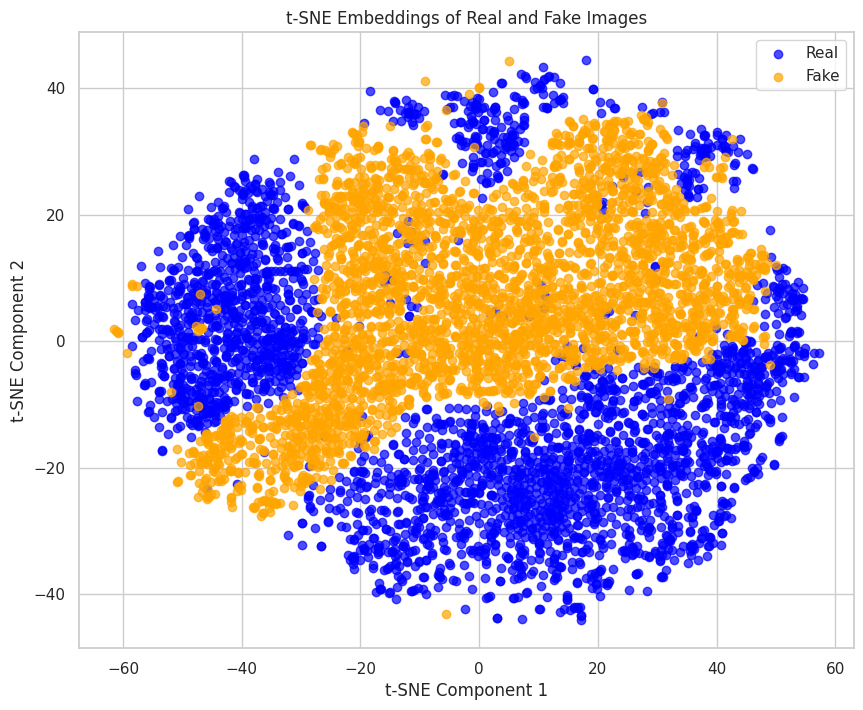

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(all_images_np)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

plt.scatter(embeddings[labels == 1, 0], embeddings[labels == 1, 1], label='Real', color='blue', alpha=0.7)

plt.scatter(embeddings[labels == 0, 0], embeddings[labels == 0, 1], label='Fake', color='orange', alpha=0.7)

plt.title('t-SNE Embeddings of Real and Fake Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

Прокомментируйте получившийся результат:

Видим, что распределения получились хорошо различимыми друг между другом: есть явный кластер из сгенерированных и 3-4 кластера из настоящих.

В идеале же распределения должны были получиться неотделимыми друг от друга. Можно попробовать увеличить количество эпох, возможно это покажет лучший результат.

Также интересно было бы увидеть, как меняются эти распределения в зависимости от эпохи обучения. По идее должно происходить нечто вроде диффузии, от изначально легко отделимых до смеси.